<a href="https://colab.research.google.com/github/Im-DaBeen/AIFFEL_quest/blob/main/Exploration_quest/Quest06/Project_ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00


In [2]:
#메모리 삭제
torch.cuda.empty_cache()

NameError: ignored

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

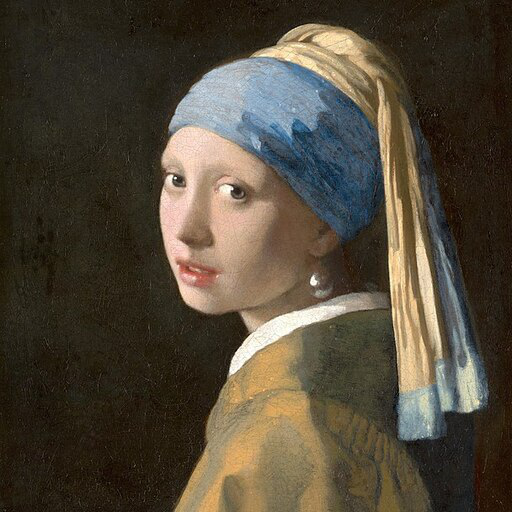

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

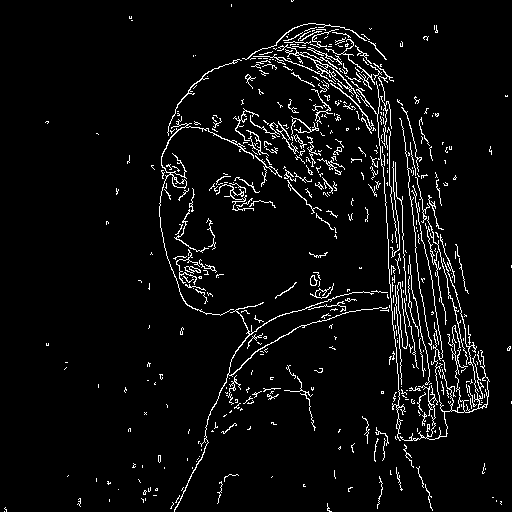

In [4]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

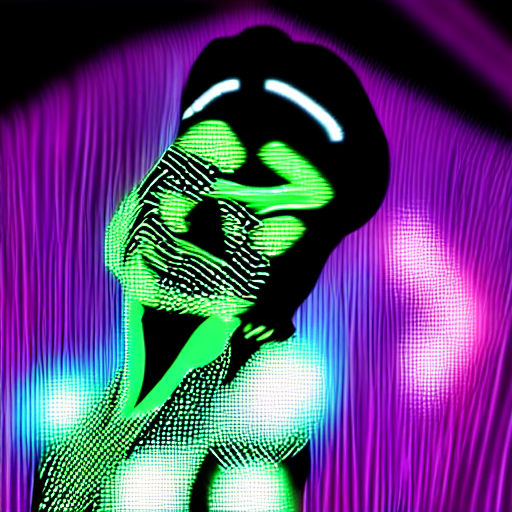

In [8]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/content/sample_data/canny_image.png")

# 생성된 이미지를 출력합니다.
canny_image

In [10]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00


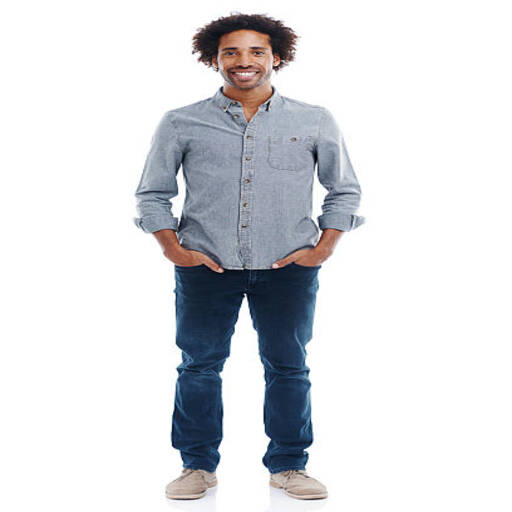

In [11]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


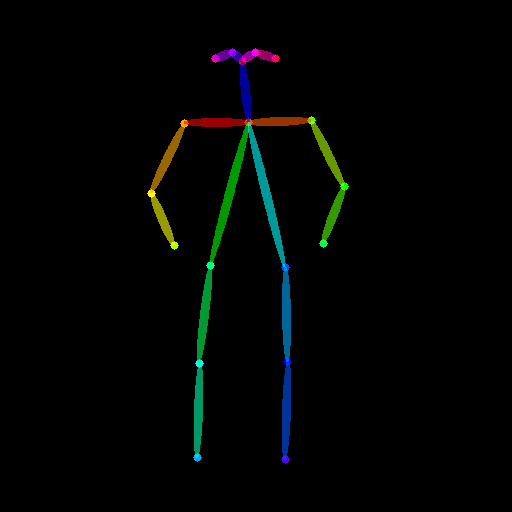

In [12]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [13]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

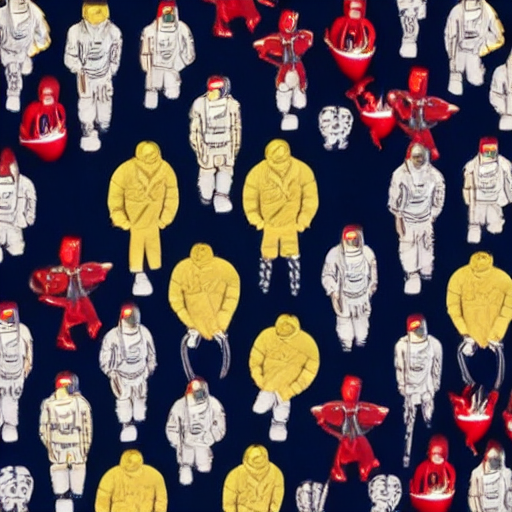

In [27]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.

images = openpose_image

# 이미지를 생성합니다.
openpose_image = openpose_pipe(
    prompt =  " Iron Man's flying spaceship",
    num_inference_steps=20,
    generator=generator,
    guidance_scale = 3.5,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image

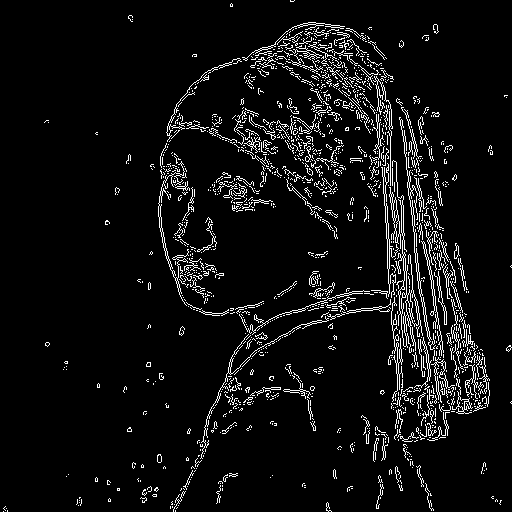

In [30]:
# Canny 알고리즘을 사용한 윤곽선 검출
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# 이미지를 불러오세요.
canny_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

#threshhold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image

cuda


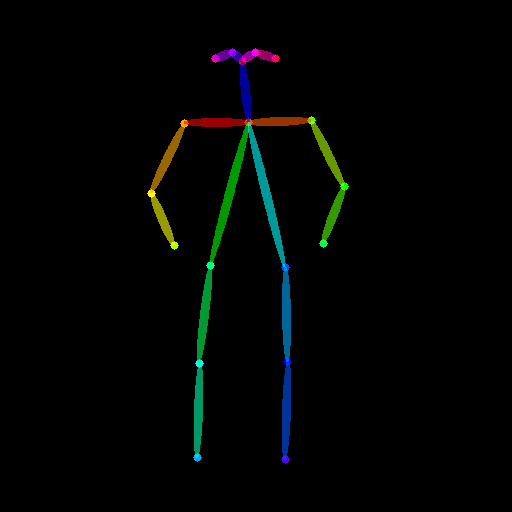

In [31]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose_image = openpose(openpose_image)
openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

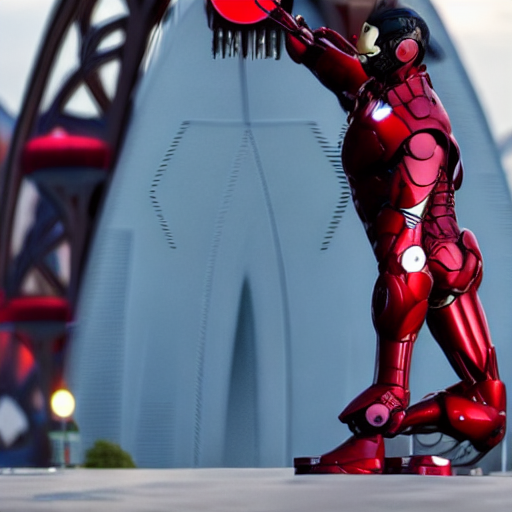

In [39]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [canny_controlnet, openpose_controlnet]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt =  "Iron Man riding a bicycle on the Han River"
#negative_prompt =  # [[YOUR CODE]]

# seed를 지정합니다.
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image = pipe(
    prompt = prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# 생성된 이미지를 저장합니다.
image.save("/content/sample_data/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image

### 회고
- chatGPT를 이용하여 이미지를 생성하는 것을 배우게 되었습니다.
- Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만드는 과정에서```pipe=StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)``` 를
```controlnet=controlnets```로 수정하고 진행이 가능했습니다.
- 프롬프트를 입력한대로 결과가 나오지 않아 아쉬웠지만 대체로 비슷한 이미지를 출력하는 모습을 확인할 수 있었습니다.